<a href="https://colab.research.google.com/github/Viaxiz/VariesDemo/blob/master/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 导入相关包
import torch
import torchvision 
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
# 查看pytorch版本和gpu是否可用
print(torch.__version__)
print(torch.cuda.is_available())

1.13.1+cu116
True


In [4]:
# 如果网络能在GPU中训练，就使用GPU；否则使用CPU进行训练
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# 这个函数包括了两个操作：将图片转换为张量，以及将图片进行归一化处理
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(mean = [0.5],std = [0.5])])
                                
# 设置了每个包中的图片数据个数
BATCH_SIZE = 64
EPOCHS = 10

In [6]:
from torchvision import datasets, transforms

In [7]:
data_train = datasets.MNIST(root = "./data/",
                            transform=transform,
                            train = True,
                            download = True)
# root 指代文件保存位置
data_test = datasets.MNIST(root="./data/",
                           transform = transform,
                           train = False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [8]:
# 建立一个数据迭代器
# 装载训练集
train_loader = torch.utils.data.DataLoader(dataset=data_train,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)
# 装载测试集
test_loader = torch.utils.data.DataLoader(dataset=data_test,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)
# batch_size设置了每批装载的数据图片为64个，shuffle设置为True在装载过程中为随机乱序

In [16]:
# 看下训练集和测试集大小：数据集包含 60,000个训练集图像以及10,000个测试集图像。PS:数据集中每张图像的大小固定（28x28像素），上面的数字都经过了尺寸标准化及居中处理，数字范围从0到9，共10个模式
print(len(data_train),len(data_test))

60000 10000


[tensor(3), tensor(9), tensor(2), tensor(5), tensor(8), tensor(0), tensor(3), tensor(9), tensor(5), tensor(5), tensor(8), tensor(8), tensor(2), tensor(1), tensor(5), tensor(8), tensor(8), tensor(9), tensor(1), tensor(1), tensor(8), tensor(5), tensor(6), tensor(1), tensor(9), tensor(1), tensor(4), tensor(2), tensor(2), tensor(0), tensor(5), tensor(4), tensor(8), tensor(5), tensor(3), tensor(3), tensor(6), tensor(8), tensor(3), tensor(3), tensor(8), tensor(8), tensor(8), tensor(2), tensor(5), tensor(7), tensor(2), tensor(9), tensor(5), tensor(6), tensor(1), tensor(9), tensor(4), tensor(7), tensor(7), tensor(6), tensor(1), tensor(4), tensor(1), tensor(0), tensor(8), tensor(0), tensor(0), tensor(0)]


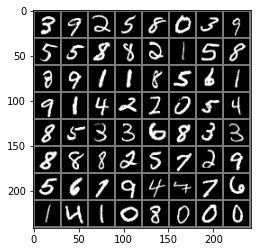

In [18]:
images, labels = next(iter(train_loader))
img = torchvision.utils.make_grid(images)

img = img.numpy().transpose(1,2,0)
std = [0.5,0.5,0.5]
mean = [0.5,0.5,0.5]
img = img*std+mean
print([labels[i] for i in range(64)])
plt.imshow(img)

下面构建数据训练模型并创建实例
参考：
[1]https://github.com/JaimeTang/PyTorch-and-mnist/blob/master/pytorch-and-mnist.ipynb

[2]https://zhuanlan.zhihu.com/p/30249139

In [9]:
class Model(torch.nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1),
                                         torch.nn.ReLU(),
                                         torch.nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
                                         torch.nn.ReLU(),
                                         torch.nn.MaxPool2d(stride=2,kernel_size=2))
        self.dense = torch.nn.Sequential(torch.nn.Linear(14*14*128,1024),
                                         torch.nn.ReLU(),
                                         torch.nn.Dropout(p=0.5),
                                         torch.nn.Linear(1024, 10))
    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, 14*14*128)
        x = self.dense(x)
        return x

# 完成数据装载后就可以构建核心程序了，这里构建的是一个包含了卷积层和全连接层的神经网络，其中卷积层使用torch.nn.Conv2d来构建，
# 激活层使用torch.nn.ReLU来构建，池化层使用torch.nn.MaxPool2d来构建，全连接层使用torch.nn.Linear来构建

# 其中定义了torch.nn.Dropout(p=0.5)防止模型的过拟合

# forward函数定义了前向传播，其实就是正常卷积路径。首先经过self.conv1(x)卷积处理，然后进行x.view(-1, 14*14*128)压缩扁平化处理，最后通过self.dense(x)全连接进行分类



In [15]:
# 在训练前可以查看神经网络架构了，print输出显示如下
print(Model())

Model(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense): Sequential(
    (0): Linear(in_features=25088, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=10, bias=True)
  )
)


模型训练过程

In [22]:
# 对Model对象进行调用，然后定义loss计算使用交叉熵，优化计算使用Adam自动化方式，最后就可以开始训练了
model = Model()
cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
# 定义训练次数为5次
n_epochs = 5
# 
# model.load_state_dict(torch.load('model_parameter.pkl'))

In [24]:
# 忘了导入这步
from torch.autograd import Variable

In [26]:
for epoch in range(n_epochs):
    running_loss = 0.0
    running_correct = 0
    print("Epoch {}/{}".format(epoch, n_epochs))
    print("-"*10)
    for data in train_loader:
        X_train, y_train = data
        X_train, y_train = Variable(X_train), Variable(y_train)
        outputs = model(X_train)
        _,pred = torch.max(outputs.data, 1)
        optimizer.zero_grad()
        loss = cost(outputs, y_train)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_correct += torch.sum(pred == y_train.data)
    testing_correct = 0
    for data in test_loader:
        X_test, y_test = data
        X_test, y_test = Variable(X_test), Variable(y_test)
        outputs = model(X_test)
        _, pred = torch.max(outputs.data, 1)
        testing_correct += torch.sum(pred == y_test.data)
    print("Loss is:{:.4f}, Train Accuracy is:{:.4f}%, Test Accuracy is:{:.4f}".format(running_loss/len(data_train),
                                                                                      100*running_correct/len(data_train),
                                                                                      100*testing_correct/len(data_test)))
# 训练完成后还可以保存训练得到的参数，方便下次导入后可供直接使用
torch.save(model.state_dict(), "model_parameter.pkl")

Epoch 0/5
----------
Loss is:0.0020, Train Accuracy is:96.1617%, Test Accuracy is:98.0600
Epoch 1/5
----------
Loss is:0.0007, Train Accuracy is:98.6183%, Test Accuracy is:98.2100
Epoch 2/5
----------
Loss is:0.0005, Train Accuracy is:99.1117%, Test Accuracy is:98.8400
Epoch 3/5
----------
Loss is:0.0003, Train Accuracy is:99.3750%, Test Accuracy is:98.8900
Epoch 4/5
----------
Loss is:0.0002, Train Accuracy is:99.4750%, Test Accuracy is:98.8200


Predict Label is: [tensor(6), tensor(7), tensor(8), tensor(1)]
Real Label is: [tensor(6), tensor(7), tensor(8), tensor(1)]


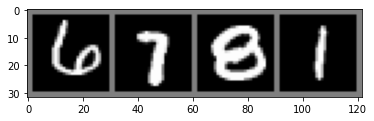

In [27]:
# 预测的代码，随机对几张测试集的图片进行预测，并做可视化展示
data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                                          batch_size = 4,
                                          shuffle = True)
X_test, y_test = next(iter(data_loader_test))
inputs = Variable(X_test)
pred = model(inputs)
_,pred = torch.max(pred, 1)

print("Predict Label is:", [ i for i in pred.data])
print("Real Label is:",[i for i in y_test])

img = torchvision.utils.make_grid(X_test)
img = img.numpy().transpose(1,2,0)

std = [0.5,0.5,0.5]
mean = [0.5,0.5,0.5]
img = img*std+mean
plt.imshow(img)